## Closed form diffusion models (CFDM) for LID estimation

This notebook contains experiments for the closed-form diffusion experiments. The premise of these experiments is that we use the same formulas from a Fokker-Planck-based estimator, however, instead of assuming we have a model that has learned the data-distribution, we assume that the data-distribution is empirical, i.e., a delta-dirac function at the data points. This allows us to derive closed-form solutions for the diffusion process, which can be used to estimate the LID of a dataset.

## Using a Gaussian example as a test-bed

Here, we will create a simple dataset by sampling from a multivariate Gaussian distribuition. To impose intrinsic dimensionality, we set the eigenvalues of the covaraiance matrix to be small (1e-6) across 8 dimensions one across 2 dimensions, thus mimicing a 2 dimensional Gaussian. The following code will generate a random dataset with this property:

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from notebook_setup import device

torch.manual_seed(0)

n_samples = 10000

mean = 10 * torch.randn(10).to(device)

# create a covariance matrix that has an almost zero eigenvalue, 3 larger eigenvalues and 6 smaller eigenvalues
eigvals = torch.tensor([1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6,  1, 1]).to(device)
# create a random orthogonal matrix
orthogonal = torch.randn(10, 10).to(device)
q, _ = torch.linalg.qr(orthogonal)
cov = q @ torch.diag(eigvals) @ q.T
# take the eigenvalues of cov
eigvals = torch.linalg.eigvalsh(cov)

# take samples from isotropic Gaussian of dimension 10
isotropic_gaussian = torch.randn(n_samples, 10).to(device)
# multiply each element of isotropic_gaussian by the square root of the eigenvalues of cov
gaussian_scaled = isotropic_gaussian * torch.sqrt(eigvals)
# transform them to have covariance cov
transformed = gaussian_scaled @ q.T
# transfoem them to have mean mean
data = transformed + mean


Now let us instantiate a CDFM LID estimator:

In [2]:
from lid.diffusions import CFDM_LID

lid_estimator = CFDM_LID(
    data=data,
    ambient_dim=10,
    device=device,
    beta_min=0.1,
    beta_max=20,
    t_max=1.0,
)

Finally, the following code will estimate LID using this closed form estimator, however, it will vary the 't' hyperparameter across the x-axis and visualize the obtained LID estimates across the y-axis. Each small trend would represent the LID estimate for a datapoint and the red line represents the average LID.

/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


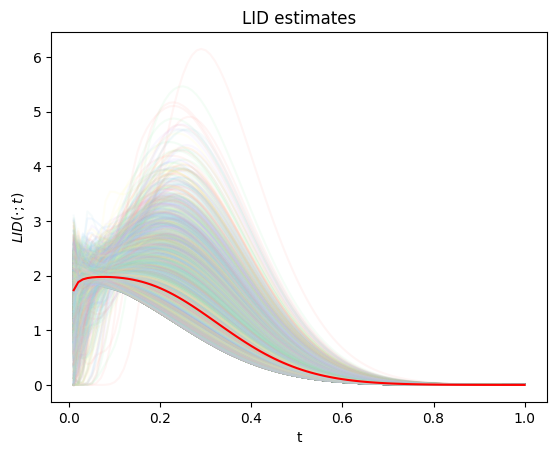

In [3]:
%autoreload 2
from visualization.notebook_utils import plot_lid_trend_simple

plot_lid_trend_simple(
    data=data,
    lid_estimator=lid_estimator,
    mode="with_preprocessing",
    argument_name="t",
    argument_values=torch.linspace(1e-2, 1.0, 100), # set the start time to 1e-2, otherwise things'll explode
)


**Expected results:** We expect the LID to be 2, as the data is generated from a 2-dimensional Gaussian distribution. The average LID therefore should plateau at 2 for small values of 't'.

## Using the Lollipop dataset

Now, let us also try out the estimator on the lollipop dataset that has three different submanifolds of dimensionality 0, 1, and 2. The following code will generate the lollipop dataset:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


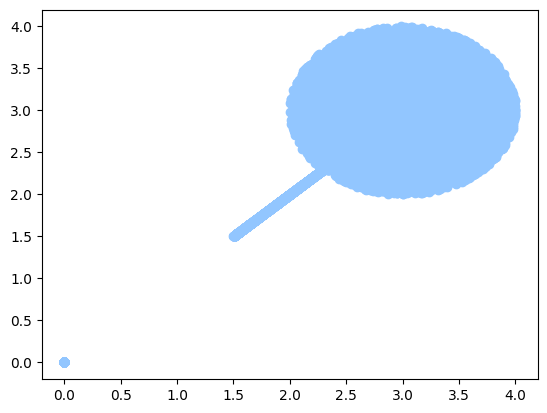

In [4]:
import matplotlib.pyplot as plt
from data.datasets.generated import LIDSyntheticDataset
from data.distributions import Lollipop
%load_ext autoreload
%autoreload 2

dset = LIDSyntheticDataset(
    size=10000,
    distribution=Lollipop(),
    seed=42,
)
plt.scatter(*dset.x.T)
plt.show()

Now let us plot the results, as before, we will vary the 't' hyperparamter, but instead of plotting the average LID, we will plot the LID of each datapoint in a scatterplot.

computing scatterplot: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]


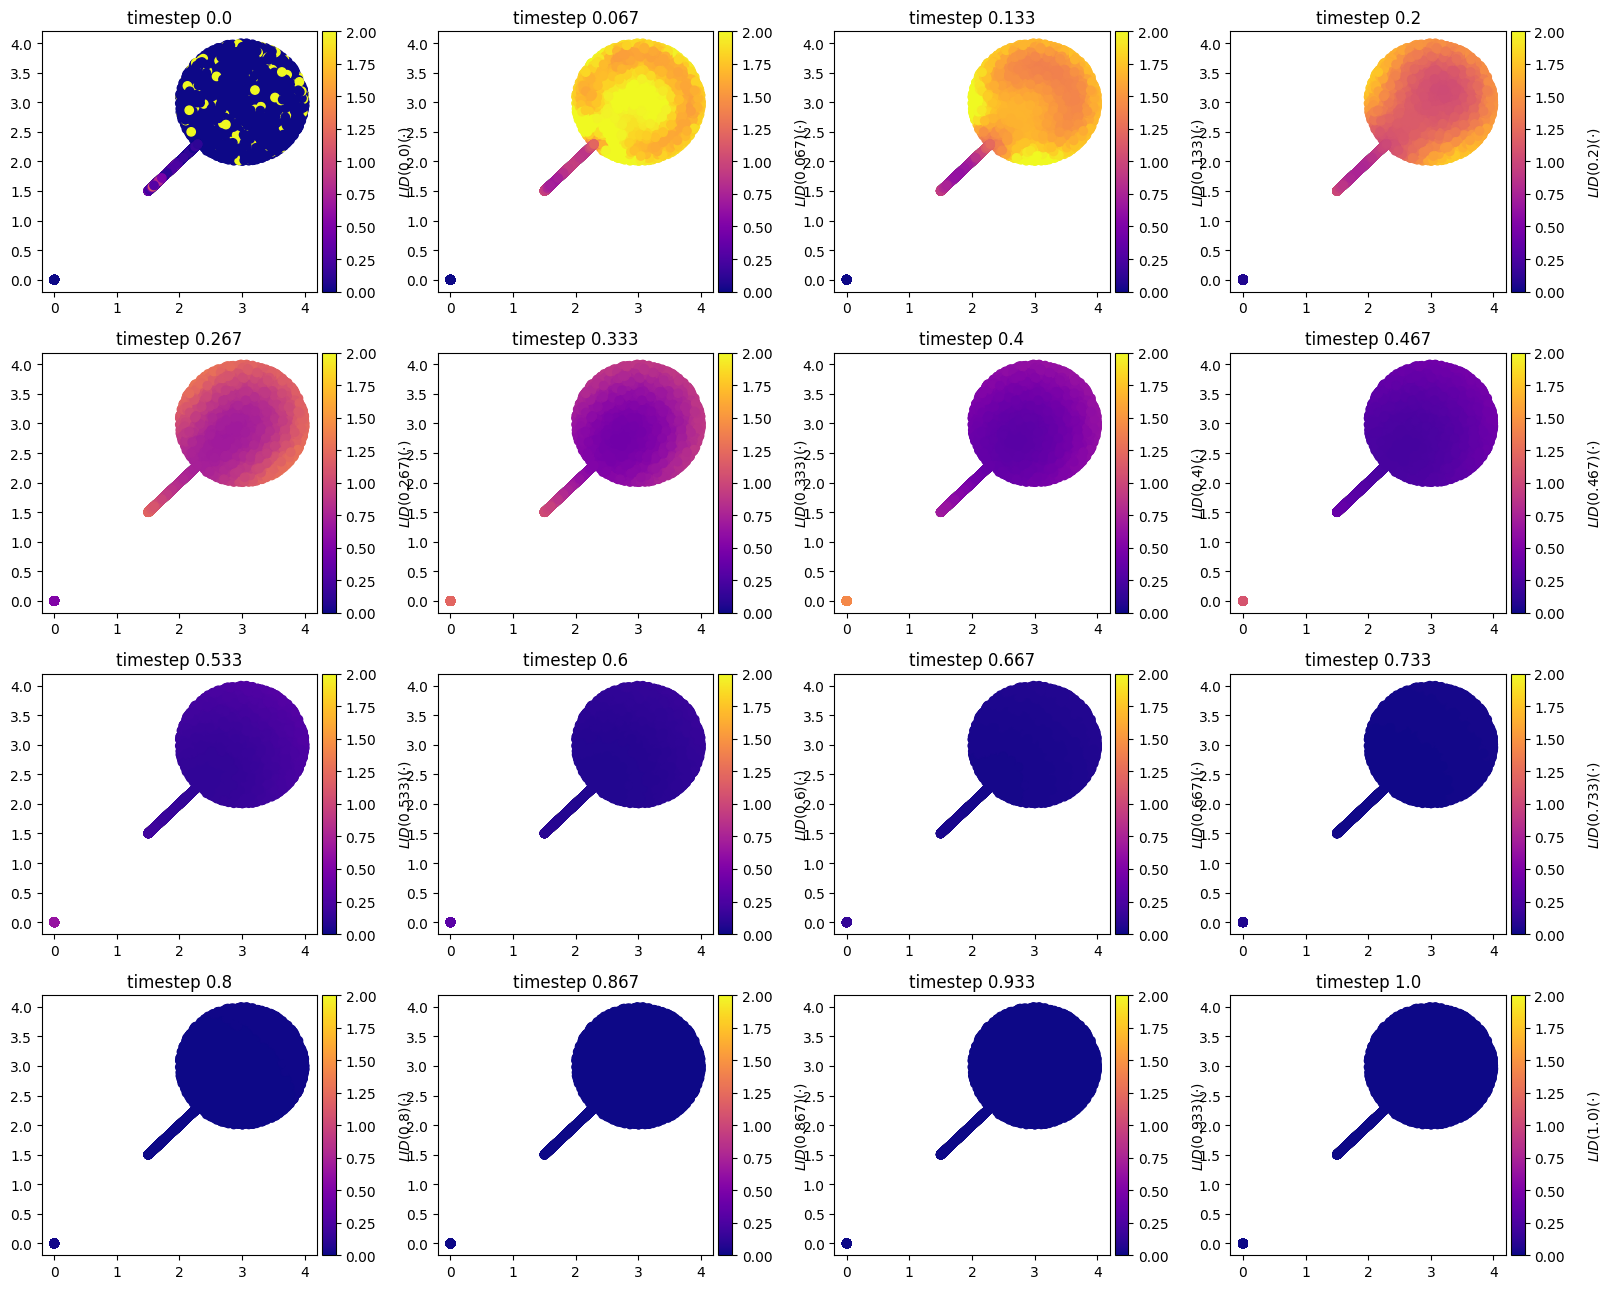

In [5]:
%autoreload 2
from visualization.notebook_utils import plot_lid_on_a_grid
import numpy as np

# instantiate the lid_estimator
lid_estimator = CFDM_LID(
    data=dset.x,
    ambient_dim=2,
    device=device,
    beta_min= 0.1,
    beta_max=20,
    t_max=1.0,
)

plot_lid_on_a_grid(
    data=dset.x,
    lid_estimator=lid_estimator,
    mode="with_preprocessing",
    argument_name="t",
    argument_values=np.linspace(1e-6, 1, 16),
)

**Expected result**: As the time increases, all the LID values become zero, but before that, there is a sweet spot where the LID values are 0, 1, and 2 for the 0, 1, and 2-dimensional submanifolds respectively.